# ЛР7 Семантическая сегментация


## Импорт библиотек

In [100]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import OxfordIIITPet
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.transforms import functional as TF
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import jaccard_score, f1_score
import torchvision
from tqdm import tqdm

# Бейзлайн

#### Параметры

In [57]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 8
NUM_EPOCHS = 5
CLASSES = 1 

#### Аугментации

In [60]:
train_transform = A.Compose([
    A.Resize(128, 128),
    A.HorizontalFlip(),
    A.Normalize(),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(128, 128),
    A.Normalize(),
    ToTensorV2(),
])

#### Загрузка датасета

In [63]:
class PetSegmentationDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        img, target = self.dataset[idx]
        mask = np.array(target)
        mask = (mask == 1).astype("float32")
        img = np.array(img)

        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented["image"]
            mask = augmented["mask"].unsqueeze(0)
        return img, mask

root = "./data"
train_set = OxfordIIITPet(root, target_types="segmentation", split="trainval", download=True)
val_set = OxfordIIITPet(root, target_types="segmentation", split="test", download=True)

train_dataset = PetSegmentationDataset(train_set, train_transform)
val_dataset = PetSegmentationDataset(val_set, val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1)

#### Модель и обучение

In [66]:
model = smp.Unet("resnet18", encoder_weights="imagenet", in_channels=3, classes=1).to(DEVICE)
loss_fn = smp.losses.DiceLoss(mode='binary')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_loss = 0
    for imgs, masks in train_loader:
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        preds = model(imgs)
        loss = loss_fn(preds, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {epoch_loss:.4f}")

Epoch 1/5, Loss: 99.2650
Epoch 2/5, Loss: 77.4027
Epoch 3/5, Loss: 69.8990
Epoch 4/5, Loss: 68.8156
Epoch 5/5, Loss: 66.3166


#### Оценка и вывод результатов

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6225708].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3088453].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8431371..2.4831371].



Avg IoU: 0.7301
Avg Dice: 0.8297


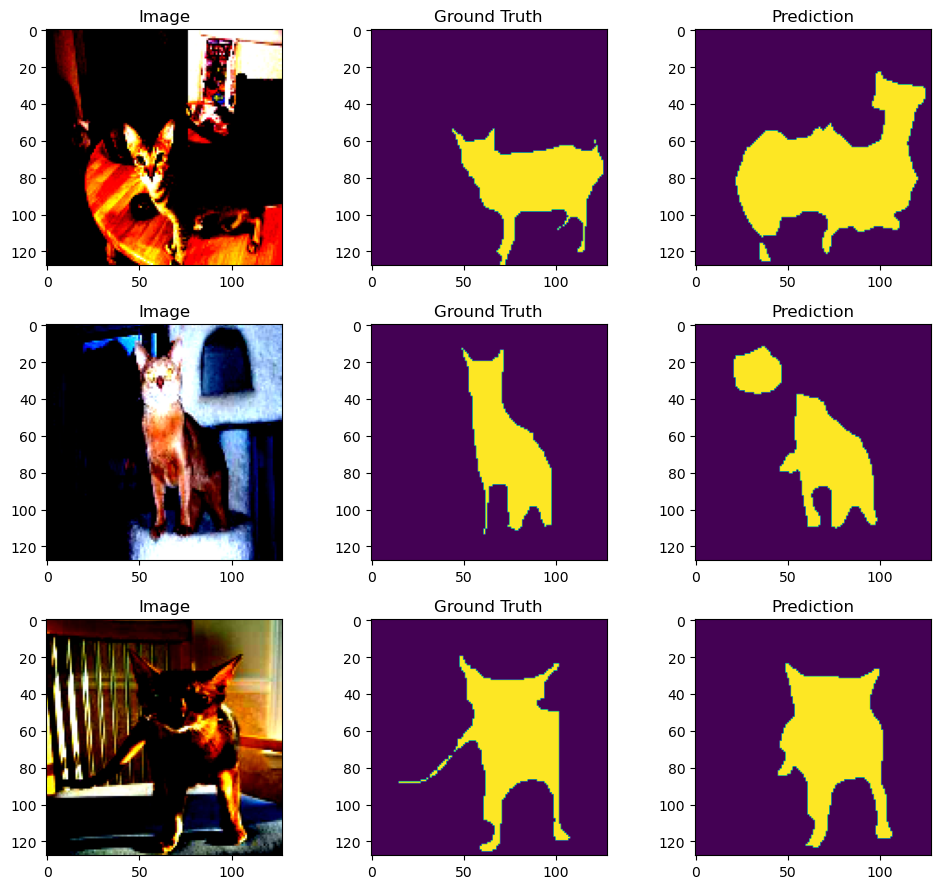

In [68]:
model.eval()
ious, dices = [], []

with torch.no_grad():
    for imgs, masks in val_loader:
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        preds = torch.sigmoid(model(imgs)) > 0.5
        iou = jaccard_score(masks.cpu().numpy().flatten(), preds.cpu().numpy().flatten())
        dice = f1_score(masks.cpu().numpy().flatten(), preds.cpu().numpy().flatten())
        ious.append(iou)
        dices.append(dice)

print(f"\nAvg IoU: {np.mean(ious):.4f}")
print(f"Avg Dice: {np.mean(dices):.4f}")

def show_predictions(model, dataset, num=3):
    model.eval()
    fig, axs = plt.subplots(num, 3, figsize=(10, num * 3))
    for i in range(num):
        img, mask = dataset[i]
        with torch.no_grad():
            pred = torch.sigmoid(model(img.unsqueeze(0).to(DEVICE))) > 0.5
        axs[i, 0].imshow(img.permute(1, 2, 0).cpu())
        axs[i, 0].set_title("Image")
        axs[i, 1].imshow(mask.squeeze().cpu())
        axs[i, 1].set_title("Ground Truth")
        axs[i, 2].imshow(pred.squeeze().cpu())
        axs[i, 2].set_title("Prediction")
    plt.tight_layout()
    plt.show()

show_predictions(model, val_dataset)

# Улучшенный бейзлайн

#### Подготовка

In [102]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

class PetDataset(torch.utils.data.Dataset):
    def __init__(self, root, split='train', transform=None):
        self.dataset = OxfordIIITPet(
            root=root,
            target_types='segmentation',
            download=True
        )
        self.indices = list(range(len(self.dataset)))
        np.random.seed(42)
        np.random.shuffle(self.indices)
        if split == 'train':
            self.indices = self.indices[:int(0.8 * len(self.dataset))]
        else:
            self.indices = self.indices[int(0.8 * len(self.dataset)):]
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        img, mask = self.dataset[self.indices[idx]]
        mask = (np.array(mask) == 1).astype(np.float32)  # только один класс (питомец)
        if self.transform:
            img = self.transform(img)
            mask = torch.tensor(mask).unsqueeze(0)
            mask = TF.resize(mask, [128, 128])
        return img, mask

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

train_dataset = PetDataset(root='./data', split='train', transform=transform)
val_dataset = PetDataset(root='./data', split='val', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

#### Модель и функция потерь

In [105]:
model = smp.Unet(encoder_name='resnet34', in_channels=3, classes=1).to(DEVICE)

dice_loss = smp.losses.DiceLoss(mode='binary')
bce_loss = torch.nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

#### Обучение

In [108]:
def train_one_epoch(model, loader):
    model.train()
    epoch_loss = 0
    for imgs, masks in tqdm(loader):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        preds = model(imgs)
        loss = dice_loss(preds, masks) + bce_loss(preds, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(loader)

#### Вывод результатов

100%|█████████████████████████████████████████| 368/368 [00:48<00:00,  7.61it/s]


Epoch 1/5 — Loss: 0.5508 — IoU: 0.7399 — Dice: 0.8398


100%|█████████████████████████████████████████| 368/368 [00:41<00:00,  8.89it/s]


Epoch 2/5 — Loss: 0.4138 — IoU: 0.7558 — Dice: 0.8492


100%|█████████████████████████████████████████| 368/368 [00:41<00:00,  8.81it/s]


Epoch 3/5 — Loss: 0.3771 — IoU: 0.7335 — Dice: 0.8320


100%|█████████████████████████████████████████| 368/368 [00:41<00:00,  8.91it/s]


Epoch 4/5 — Loss: 0.3372 — IoU: 0.7278 — Dice: 0.8270


100%|█████████████████████████████████████████| 368/368 [00:41<00:00,  8.96it/s]


Epoch 5/5 — Loss: 0.3310 — IoU: 0.7627 — Dice: 0.8550


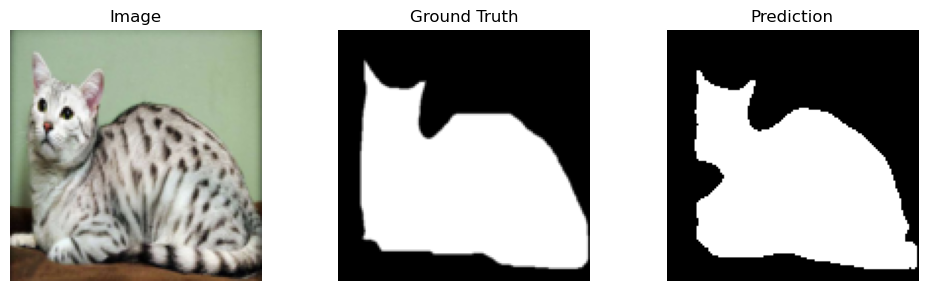

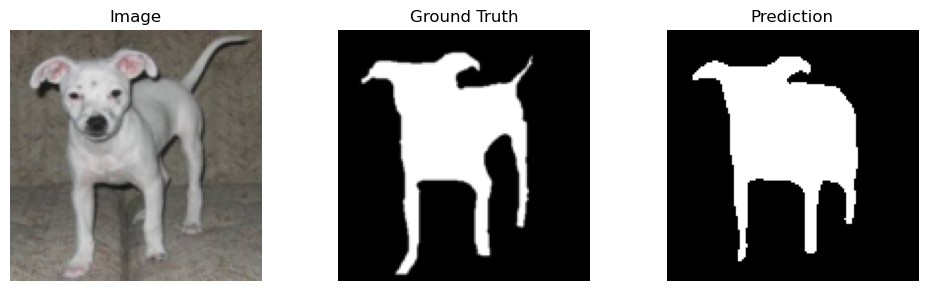

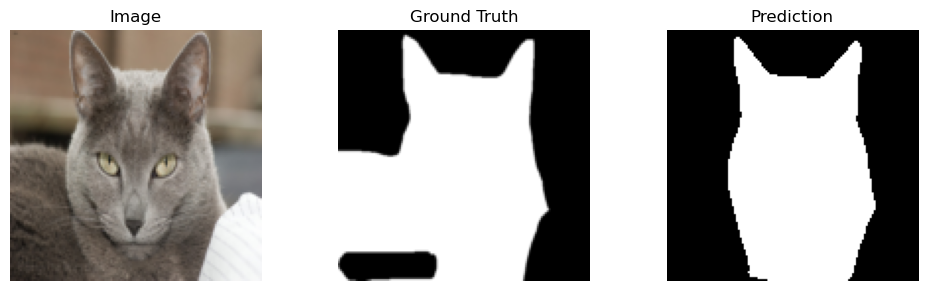

In [111]:
def evaluate(model, loader):
    model.eval()
    iou_scores = []
    dice_scores = []
    with torch.no_grad():
        for imgs, masks in loader:
            imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
            preds = torch.sigmoid(model(imgs))
            preds = (preds > 0.5).float()

            intersection = (preds * masks).sum((1, 2, 3))
            union = preds.sum((1, 2, 3)) + masks.sum((1, 2, 3))
            iou = (intersection + 1e-7) / (union - intersection + 1e-7)
            dice = (2 * intersection + 1e-7) / (preds.sum((1, 2, 3)) + masks.sum((1, 2, 3)) + 1e-7)

            iou_scores.extend(iou.cpu().numpy())
            dice_scores.extend(dice.cpu().numpy())

    return np.mean(iou_scores), np.mean(dice_scores)

for epoch in range(5):
    loss = train_one_epoch(model, train_loader)
    iou, dice = evaluate(model, val_loader)
    scheduler.step(loss)
    print(f"Epoch {epoch+1}/5 — Loss: {loss:.4f} — IoU: {iou:.4f} — Dice: {dice:.4f}")

def show_predictions(model, loader, num=3):
    model.eval()
    imgs, masks = next(iter(loader))
    imgs, masks = imgs[:num].to(DEVICE), masks[:num].to(DEVICE)
    with torch.no_grad():
        preds = torch.sigmoid(model(imgs))
        preds = (preds > 0.5).float()

    for i in range(num):
        fig, axs = plt.subplots(1, 3, figsize=(10, 3))
        axs[0].imshow(imgs[i].permute(1, 2, 0).cpu())
        axs[0].set_title('Image')
        axs[1].imshow(masks[i][0].cpu(), cmap='gray')
        axs[1].set_title('Ground Truth')
        axs[2].imshow(preds[i][0].cpu(), cmap='gray')
        axs[2].set_title('Prediction')
        for ax in axs:
            ax.axis('off')
        plt.tight_layout()
        plt.show()

show_predictions(model, val_loader)